# Predicting House Sale Prices

> In this course, we started by building intuition for model based learning, explored how the linear regression model worked, understood how the two different approaches to model fitting worked, and some techniques for cleaning, transforming, and selecting features. In this guided project, you can practice what you learned in this course by exploring ways to improve the models we built.

>You'll work with housing data for the city of Ames, Iowa, United States from 2006 to 2010. You can read more about why the data was collected here. You can also read about the different columns in the data here.

>Let's start by setting up a pipeline of functions that will let us quickly iterate on different models.

- train
- transform_features()
- select_features()
- train_and_test()
- view resulting rmse_values and avg_mse


In [1]:
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import KFold

%matplotlib inline
import seaborn as sns

In [2]:
df = pd.read_csv('AmesHousing.tsv', delimiter = '\t')

In [3]:
def transform_features(df):
    return df

def select_features(df):
    return df[['Gr Liv Area', "SalePrice"]]

def train_and_test(df):
    train = df[:1460]
    test = df[1460:]
    
    numeric_train = train.select_dtypes(include = ['integer', 'float'])
    numeric_test = test.select_dtypes(include = ['integer', 'float'])
    
    features = numeric_train.columns.drop('SalePrice')
    
    model = linear_model.LinearRegression()
    model.fit(train[features], train['SalePrice'])
    
    predictions = model.predict(test[features])
    mse = mean_squared_error(test['SalePrice'], predictions)
    rmse = np.sqrt(mse)
    
    return rmse

transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

57088.25161263909

# Feature Engineering
- Handle missing values:
    - All columns:
        - Drop any with 5% or more missing values for now.
    - Text columns:
        - Drop any with 1 or more missing values for now.
    - Numerical columns:
        - For columns with missing values, fill in with the most common value in -that column

1: All columns: Drop any with 5% or more missing values for now.

In [4]:
num_missing = df.isnull().sum()
#num_missing
#series obj: col name - num null val in col

In [5]:
drop_missing_cols = num_missing[(num_missing > len(df)/20)].sort_values()
#type(drop_missing_cols)
df = df.drop(drop_missing_cols.index, axis=1)

2: Text columns: Drop any with 1 or more missing values for now.

In [6]:
text_mv_count = df.select_dtypes(include = ['object']).isnull().sum().sort_values(ascending=False)

In [7]:
#text_mv_count

In [8]:
drop_missing_cols_2 = text_mv_count[text_mv_count>0]
df = df.drop(drop_missing_cols_2.index, axis = 1)

In [9]:
drop_missing_cols_2

Bsmt Exposure     83
BsmtFin Type 2    81
BsmtFin Type 1    80
Bsmt Qual         80
Bsmt Cond         80
Mas Vnr Type      23
Electrical         1
dtype: int64

3: Numerical columns: For columns with missing values, fill in with the most common value in -that column

In [10]:
#compute columnswise missing numeric value counts
num_missing = df.select_dtypes(include = ['integer', 'float']).isnull().sum().sort_values()
fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
fixable_numeric_cols

Garage Area        1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
BsmtFin SF 1       1
Garage Cars        1
Bsmt Full Bath     2
Bsmt Half Bath     2
Mas Vnr Area      23
dtype: int64

In [11]:

## Compute the most common value for each column in `fixable_nmeric_missing_cols`.
replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
replacement_values_dict

{'Bsmt Full Bath': 0.0,
 'Bsmt Half Bath': 0.0,
 'Bsmt Unf SF': 0.0,
 'BsmtFin SF 1': 0.0,
 'BsmtFin SF 2': 0.0,
 'Garage Area': 0.0,
 'Garage Cars': 2.0,
 'Mas Vnr Area': 0.0,
 'Total Bsmt SF': 0.0}

In [12]:
## Use `pd.DataFrame.fillna()` to replace missing values.
df = df.fillna(replacement_values_dict)

In [13]:
## Verify that every column has 0 missing values
df.isnull().sum().value_counts()

0    64
dtype: int64

What new features can we create, that better capture the information in some of the features?



In [14]:
years_sold = df['Yr Sold'] - df['Year Built']
years_sold[years_sold < 0]

2180   -1
dtype: int64

In [15]:
years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
years_since_remod[years_since_remod < 0]

1702   -1
2180   -2
2181   -1
dtype: int64

In [16]:
## Create new columns
df['Years Before Sale'] = years_sold
df['Years Since Remod'] = years_since_remod

## Drop rows with negative values for both of these new features
df = df.drop([1702, 2180, 2181], axis=0)

## No longer need original year columns
df = df.drop(["Year Built", "Year Remod/Add"], axis = 1)

In [17]:

## Drop columns that aren't useful for ML
df = df.drop(["PID", "Order"], axis=1)

## Drop columns that leak info about the final sale
df = df.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)

Let's update our functions


In [18]:
def transform_features(df):
    #makes series obj to get num missing for each column
    num_missing = df.isnull().sum()
    #creates series that has info on if missing more than 5% 
    drop_missing_cols = num_missing[(num_missing > len(df)/20)].sort_values()
    #drops those columns missing more than 5% data
    df = df.drop(drop_missing_cols.index, axis=1)
    
    #next drop text columns with more than 1 missing value
    text_mv_count = df.select_dtypes(include = ['object']).isnull().sum().sort_values(ascending=False)
    drop_missing_cols_2 = text_mv_count[text_mv_count>0]
    df = df.drop(drop_missing_cols_2.index, axis = 1)
    
    #compute columnswise missing numeric value counts
    num_missing = df.select_dtypes(include = ['integer', 'float']).isnull().sum().sort_values()
    fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
    ## Compute the most common value for each column in `fixable_nmeric_missing_cols`.
    replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
    ## Use `pd.DataFrame.fillna()` to replace missing values.
    df = df.fillna(replacement_values_dict)
    
    #create some features
    years_sold = df['Yr Sold'] - df['Year Built']
    years_sold[years_sold < 0]
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    years_since_remod[years_since_remod < 0]
    ## Create new columns
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod

    ## Drop rows with negative values for both of these new features
    df = df.drop([1702, 2180, 2181], axis=0)

    ## No longer need original year columns, or columns not useful for ML or columns that leak final sale data
    df = df.drop(["Year Built", "Year Remod/Add","PID", "Order","Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis = 1)
    
    return df

def select_features(df):
    return df[['Gr Liv Area', "SalePrice"]]

def train_and_test(df):
    train = df[:1460]
    test = df[1460:]
    
    numeric_train = train.select_dtypes(include = ['integer', 'float'])
    numeric_test = test.select_dtypes(include = ['integer', 'float'])
    
    features = numeric_train.columns.drop('SalePrice')
    
    model = linear_model.LinearRegression()
    model.fit(train[features], train['SalePrice'])
    
    predictions = model.predict(test[features])
    mse = mean_squared_error(test['SalePrice'], predictions)
    rmse = np.sqrt(mse)
    
    return rmse

df = pd.read_csv('AmesHousing.tsv', delimiter = '\t')
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

55275.36731241307

# Feature Selection 
> Now that we have cleaned and transformed a lot of the features in the data set, it's time to move on to feature selection for numerical features.

In [19]:
#generate a correlation heatmap of numerical features in the training data set
numerical_df = transform_df.select_dtypes(include=['int', 'float'])
numerical_df

,MS SubClass,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,Years Before Sale,Years Since Remod
0,20,31770,6,5,112.0,639.0,0.0,441.0,1080.0,1656,0,0,1656,1.0,0.0,1,0,3,1,7,2,2.0,528.0,210,62,0,0,0,0,0,215000,50,50
1,20,11622,5,6,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1.0,730.0,140,0,0,0,120,0,0,105000,49,49
2,20,14267,6,6,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1.0,312.0,393,36,0,0,0,0,12500,172000,52,52
3,20,11160,7,5,0.0,1065.0,0.0,1045.0,2110.0,2110,0,0,2110,1.0,0.0,2,1,3,1,8,2,2.0,522.0,0,0,0,0,0,0,0,244000,42,42
4,60,13830,5,5,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,2.0,482.0,212,34,0,0,0,0,0,189900,13,12
5,60,9978,6,6,20.0,602.0,0.0,324.0,926.0,926,678,0,1604,0.0,0.0,2,1,3,1,7,1,2.0,470.0,360,36,0,0,0,0,0,195500,12,12
6,120,4920,8,5,0.0,616.0,0.0,722.0,1338.0,1338,0,0,1338,1.0,0.0,2,0,2,1,6,0,2.0,582.0,0,0,170,0,0,0,0,213500,9,9
7,120,5005,8,5,0.0,263.0,0.0,1017.0,1280.0,1280,0,0,1280,0.0,0.0,2,0,2,1,5,0,2.0,506.0,0,82,0,0,144,0,0,191500,18,18
8,120,5389,8,5,0.0,1180.0,0.0,415.0,1595.0,1616,0,0,1616,1.0,0.0,2,0,2,1,5,1,2.0,608.0,237,152,0,0,0,0,0,236500,15,14
9,60,7500,7,5,0.0,0.0,0.0,994.0,994.0,1028,776,0,1804,0.0,0.0,2,1,3,1,7,1,2.0,442.0,140,60,0,0,0,0,0,189000,11,11


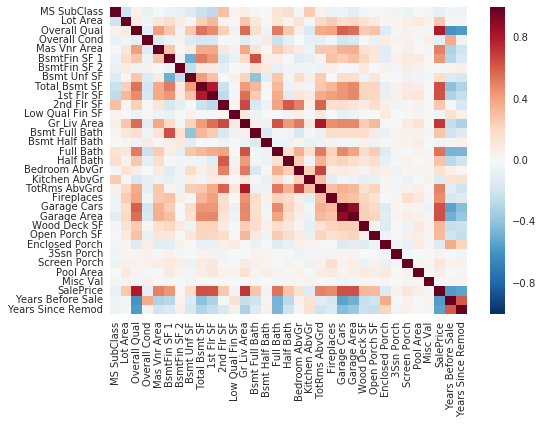

In [20]:
x = numerical_df.corr()
hm = sns.heatmap(x)

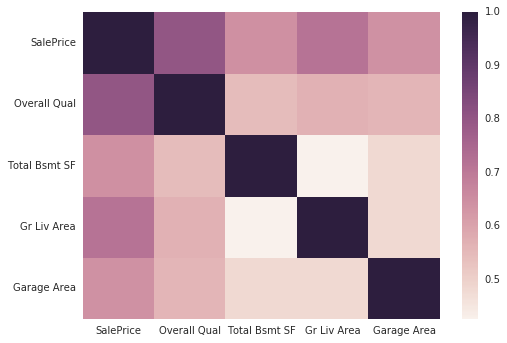

In [21]:
#calc correlation coeff for cols that corr well with SalePrice
high_corr_cols = ["SalePrice",'Overall Qual', 'Total Bsmt SF', "Gr Liv Area", "Garage Area"]
hm2 = sns.heatmap(numerical_df[high_corr_cols].corr())

In [22]:
abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values(ascending=False)
abs_corr_coeffs

SalePrice            1.000000
Overall Qual         0.801206
Gr Liv Area          0.717596
Garage Cars          0.648361
Total Bsmt SF        0.644012
Garage Area          0.641425
1st Flr SF           0.635185
Years Before Sale    0.558979
Full Bath            0.546118
Years Since Remod    0.534985
Mas Vnr Area         0.506983
TotRms AbvGrd        0.498574
Fireplaces           0.474831
BsmtFin SF 1         0.439284
Wood Deck SF         0.328183
Open Porch SF        0.316262
Half Bath            0.284871
Bsmt Full Bath       0.276258
2nd Flr SF           0.269601
Lot Area             0.267520
Bsmt Unf SF          0.182751
Bedroom AbvGr        0.143916
Enclosed Porch       0.128685
Kitchen AbvGr        0.119760
Screen Porch         0.112280
Overall Cond         0.101540
MS SubClass          0.085128
Pool Area            0.068438
Low Qual Fin SF      0.037629
Bsmt Half Bath       0.035875
3Ssn Porch           0.032268
Misc Val             0.019273
BsmtFin SF 2         0.006127
Name: Sale

In [23]:
## Let's only keep columns with a correlation coefficient of larger than 0.4 (arbitrary, worth experimenting later!)
abs_corr_coeffs[abs_corr_coeffs > 0.4]

SalePrice            1.000000
Overall Qual         0.801206
Gr Liv Area          0.717596
Garage Cars          0.648361
Total Bsmt SF        0.644012
Garage Area          0.641425
1st Flr SF           0.635185
Years Before Sale    0.558979
Full Bath            0.546118
Years Since Remod    0.534985
Mas Vnr Area         0.506983
TotRms AbvGrd        0.498574
Fireplaces           0.474831
BsmtFin SF 1         0.439284
Name: SalePrice, dtype: float64

In [24]:
## Drop columns with less than 0.4 correlation with SalePrice
transform_df = transform_df.drop(abs_corr_coeffs[abs_corr_coeffs < 0.4].index, axis=1)

In [25]:
#look at categorical data convert those

## Create a list of column names from documentation that are *meant* to be categorical
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

In [26]:
## Which categorical columns have we still carried with us? We'll test tehse 
transform_cat_cols = []
for col in nominal_features:
    if col in transform_df.columns:
        transform_cat_cols.append(col)

## How many unique values in each categorical column?
uniqueness_counts = transform_df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
## Aribtrary cutoff of 10 unique values (worth experimenting)
drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
transform_df = transform_df.drop(drop_nonuniq_cols, axis=1)

## Select just the remaining text columns and convert to categorical
text_cols = transform_df.select_dtypes(include=['object'])
for col in text_cols:
    transform_df[col] = transform_df[col].astype('category')
    
## Create dummy columns and add back to the dataframe!
transform_df = pd.concat([
    transform_df, 
    pd.get_dummies(transform_df.select_dtypes(include=['category']))
], axis=1).drop(text_cols,axis=1)

Update select_features() with the above experiements

In [28]:
def transform_features(df):
    num_missing = df.isnull().sum()
    drop_missing_cols = num_missing[(num_missing > len(df)/20)].sort_values()
    df = df.drop(drop_missing_cols.index, axis=1)
    
    text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
    drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]
    df = df.drop(drop_missing_cols_2.index, axis=1)
    
    num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
    fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
    replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
    df = df.fillna(replacement_values_dict)
    
    years_sold = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod
    df = df.drop([1702, 2180, 2181], axis=0)

    df = df.drop(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type", "Year Built", "Year Remod/Add"], axis=1)
    return df

def select_features(df, coeff_threshold=0.4, uniq_threshold=10):
    numerical_df = df.select_dtypes(include=['int', 'float'])
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < coeff_threshold].index, axis=1)
    
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)

    uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1).drop(text_cols,axis=1)
    
    return df

def train_and_test(df, k=0):
    numeric_df = df.select_dtypes(include=['integer', 'float'])
    features = numeric_df.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]

        lr.fit(train[features], train["SalePrice"])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test["SalePrice"], predictions)
        rmse = np.sqrt(mse)

        return rmse
    
    if k == 1:
        # Randomize *all* rows (frac=1) from `df` and return
        shuffled_df = df.sample(frac=1, )
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train["SalePrice"])
        predictions_one = lr.predict(test[features])        
        
        mse_one = mean_squared_error(test["SalePrice"], predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        lr.fit(test[features], test["SalePrice"])
        predictions_two = lr.predict(train[features])        
       
        mse_two = mean_squared_error(train["SalePrice"], predictions_two)
        rmse_two = np.sqrt(mse_two)
        
        avg_rmse = np.mean([rmse_one, rmse_two])
        print(rmse_one)
        print(rmse_two)
        return avg_rmse
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test["SalePrice"], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse

df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df, k=4)

rmse

[30688.490853226755, 24783.299063000337, 37053.81398884517, 24739.1736990907]


29316.19440104074